# Data Wrangling

### Table of Contents

* [0.0 Data Cleaning](#data_clean)
    * [0.1 Missing Values](#missing_values)
    * [0.2 Additional Drops](#additional_drops)
    * [0.3 Imputation](#imputation)
    * [0.4 Standardization](#standardization)
    * [0.5 Preview](#preview)
    * [0.6 EDA](#eda)
* [1.0 Feature Engineering](#feat_eng)
    * [1.1 Date Features](#date_feat)
    * [1.2 Range Features](#range_feat)
    * [1.3 Target ](#target)
* [Output](#output) 

## 0.0 Data Cleaning <a class="anchor" id="#data_clean"></a>

In [1]:
# Reload .py auxiliary file
%load_ext autoreload
%autoreload 2

# Imports
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import project_utils as pu
import seaborn as sns
import warnings

# Options
%matplotlib inline
pd.pandas.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset into a pandas dataframe
df = pd.read_csv('./accepted_2007_to_2018Q4.csv',
                 encoding='utf-8',
                 na_values=[' ', 'ANY', 'NONE', 'OTHER'],
                 parse_dates=['issue_d', 'earliest_cr_line'],
                 skipinitialspace = True)

In [3]:
# Unique values of target value
df['loan_status'].unique()

array(['Fully Paid', 'Current', 'Charged Off', 'In Grace Period',
       'Late (31-120 days)', 'Late (16-30 days)', 'Default', nan,
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [4]:
# Filter only records with information about completed loans
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off', 'Default'])]

### 0.1 Missing Values <a class="anchor" id="missing_values"></a>

In [5]:
# Percentage of null in every feature
null_percentage = df.isnull().sum() / df.shape[0] * 100

# List of features having more than 60% null
empty_cols = null_percentage[null_percentage > 60].keys()

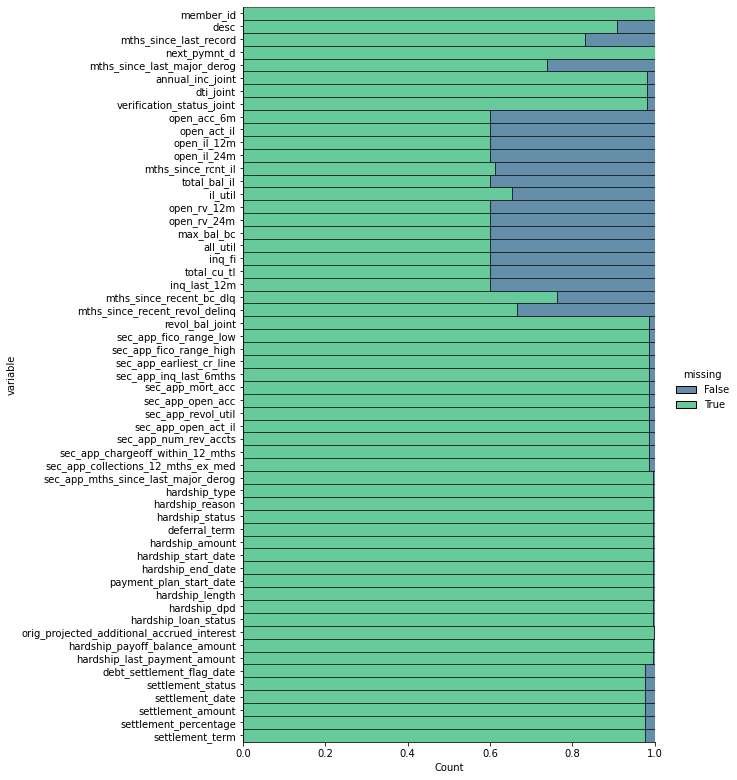

In [6]:
# Visualize features having more than 60% null
#plt.figure(figsize=(10, 40))

sns.displot(data=df[empty_cols].isna().melt(value_name="missing"),
            y="variable",
            hue="missing",
            multiple="fill",
            aspect=2,
            palette='viridis')

plt.gcf().set_size_inches(10, 12)

plt.savefig("./output/missing_data.png", bbox_inches='tight', dpi=600)

In [7]:
# Drop features having more missing values than the threshold empirically set
df.drop(empty_cols, axis=1, inplace=True)

# Drop observations having more missing values than 90% null
df.dropna(axis=0, thresh=df.shape[1]*0.1, inplace=True)

### 0.2 Additional Drops <a class="anchor" id="additional_drops"></a>

In [8]:
# Features that couldn't be used because:
cols_to_drop = ['id', # id column
                'url', # id column
                'int_rate', # biased by platform
                'installment', # biased by platform
                'grade', # biased by platform
                'sub_grade', # biased by platform
                'emp_title', # fairness
                'zip_code', # fairness
                'addr_state', # fairness
                'title', # description
                'out_prncp', # data leakage
                'out_prncp_inv', # data leakage
                'total_pymnt', # data leakage
                'total_pymnt_inv', # data leakage
                'total_rec_prncp', # data leakage
                'total_rec_int', # data leakage
                'total_rec_late_fee', # data leakage
                'recoveries', # data leakage
                'collection_recovery_fee', # data leakage
                'last_pymnt_d', # data leakage
                'last_pymnt_amnt', # data leakage
                'debt_settlement_flag', # data leakage
                'last_credit_pull_d', # data leakage
                'last_fico_range_high', # data leakage
                'last_fico_range_low' # data leakage
               ]

# Drop columns listed above
df.drop(cols_to_drop, axis=1, inplace=True)

### 0.3 Imputation <a class="anchor" id="imputation"></a>

In [9]:
# Impute 0 for numerical columns and 'na' for categorical features
df = df.fillna(0).fillna('na')

### 0.4 Standardization <a class="anchor" id="standardization"></a>

In [10]:
# All numeric features
num_columns = list(df.select_dtypes(include=['float64', 'Int64']).columns)

# Needed float type features
float_columns = ['int_rate',
                'dti',
                'revol_util',
                'out_prncp_inv',
                'dti_joint',
                'il_util',
                'bc_util',
                'pct_tl_nvr_dlq',
                'percent_bc_gt_75',
                'sec_app_revol_util']

# Convert selected features to int
df = pu.convert_column_type(dataframe=df, dtype=np.int64, columns=num_columns, excl_list=float_columns)

### 0.5 Preview <a class="anchor" id="preview"></a>

In [11]:
df.head(3)

loan_amnt  funded_amnt  funded_amnt_inv       term emp_length  \
0       3600         3600             3600  36 months  10+ years   
1      24700        24700            24700  36 months  10+ years   
2      20000        20000            20000  60 months  10+ years   

  home_ownership  annual_inc verification_status    issue_d loan_status  \
0       MORTGAGE       55000        Not Verified 2015-12-01  Fully Paid   
1       MORTGAGE       65000        Not Verified 2015-12-01  Fully Paid   
2       MORTGAGE       63000        Not Verified 2015-12-01  Fully Paid   

  pymnt_plan             purpose    dti  delinq_2yrs earliest_cr_line  \
0          n  debt_consolidation   5.91            0       2003-08-01   
1          n      small_business  16.06            1       1999-12-01   
2          n    home_improvement  10.78            0       2000-08-01   

   fico_range_low  fico_range_high  inq_last_6mths  mths_since_last_delinq  \
0             675              679               1                      30   
1             715              719               4                       6   
2             695              699               0                       0   

   open_acc  pub_rec  revol_bal  revol_util  total_acc initial_list_status  \
0         7        0       2765        29.7         13                   w   
1        22        0      21470        19.2         38                   w   
2         6        0       7869        56.2         18                   w   

   collections_12_mths_ex_med  policy_code application_type  acc_now_delinq  \
0                           0            1       Individual               0   
1                           0            1       Individual               0   
2                           0            1        Joint App               0   

   tot_coll_amt  tot_cur_bal  total_rev_hi_lim  acc_open_past_24mths  \
0           722       144904              9300                     4   
1             0       204396            111800                     4   
2             0       189699             14000                     6   

   avg_cur_bal  bc_open_to_buy  bc_util  chargeoff_within_12_mths  \
0        20701            1506     37.2                         0   
1         9733           57830     27.1                         0   
2        31617            2737     55.9                         0   

   delinq_amnt  mo_sin_old_il_acct  mo_sin_old_rev_tl_op  \
0            0                 148                   128   
1            0                 113                   192   
2            0                 125                   184   

   mo_sin_rcnt_rev_tl_op  mo_sin_rcnt_tl  mort_acc  mths_since_recent_bc  \
0                      3               3         1                     4   
1                      2               2         4                     2   
2                     14              14         5                   101   

   mths_since_recent_inq  num_accts_ever_120_pd  num_actv_bc_tl  \
0                      4                      2               2   
1                      0                      0               5   
2                     10                      0               2   

   num_actv_rev_tl  num_bc_sats  num_bc_tl  num_il_tl  num_op_rev_tl  \
0                4            2          5          3              4   
1                5           13         17          6             20   
2                3            2          4          6              4   

   num_rev_accts  num_rev_tl_bal_gt_0  num_sats  num_tl_120dpd_2m  \
0              9                    4         7                 0   
1             27                    5        22                 0   
2              7                    3         6                 0   

   num_tl_30dpd  num_tl_90g_dpd_24m  num_tl_op_past_12m  pct_tl_nvr_dlq  \
0             0                   0                   3            76.9   
1             0                   0                   2            97.4   
2             0      

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1345350 entries, 0 to 2260697
Data columns (total 69 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   loan_amnt                   1345350 non-null  int64         
 1   funded_amnt                 1345350 non-null  int64         
 2   funded_amnt_inv             1345350 non-null  int64         
 3   term                        1345350 non-null  object        
 4   emp_length                  1345350 non-null  object        
 5   home_ownership              1345350 non-null  object        
 6   annual_inc                  1345350 non-null  int64         
 7   verification_status         1345350 non-null  object        
 8   issue_d                     1345350 non-null  datetime64[ns]
 9   loan_status                 1345350 non-null  object        
 10  pymnt_plan                  1345350 non-null  object        
 11  purpose                 

### 0.6 EDA <a class="anchor" id="eda"></a>

In [13]:
# Measures of central tendency and dispersion (numerical features)
df.describe().transpose().apply(lambda x: x.apply('{0:.1f}'.format))

count      mean       std    min      25%  \
loan_amnt                   1345350.0   14420.0    8717.1  500.0   8000.0   
funded_amnt                 1345350.0   14411.6    8713.2  500.0   8000.0   
funded_amnt_inv             1345350.0   14389.1    8715.5    0.0   7875.0   
annual_inc                  1345350.0   76247.6   69924.9    0.0  45780.0   
dti                         1345350.0      18.3      11.2   -1.0     11.8   
delinq_2yrs                 1345350.0       0.3       0.9    0.0      0.0   
fico_range_low              1345350.0     696.2      31.9  625.0    670.0   
fico_range_high             1345350.0     700.2      31.9  629.0    674.0   
inq_last_6mths              1345350.0       0.7       0.9    0.0      0.0   
mths_since_last_delinq      1345350.0      17.0      23.1    0.0      0.0   
open_acc                    1345350.0      11.6       5.5    0.0      8.0   
pub_rec                     1345350.0       0.2       0.6    0.0      0.0   
revol_bal                   1345350.0   16248.0   22327.9    0.0   5943.0   
revol_util                  1345350.0      51.8      24.5    0.0     33.4   
total_acc                   1345350.0      25.0      12.0    2.0     16.0   
collections_12_mths_ex_med  1345350.0       0.0       0.1    0.0      0.0   
policy_code                 1345350.0       1.0       0.0    1.0      1.0   
acc_now_delinq              1345350.0       0.0       0.1    0.0      0.0   
tot_coll_amt                1345350.0     236.9   10783.7    0.0      0.0   
tot_cur_bal                 1345350.0  134049.4  156604.3    0.0  25222.0   
total_rev_hi_lim            1345350.0   31144.9   36421.5    0.0  12600.0   
acc_open_past_24mths        1345350.0       4.5       3.2    0.0      2.0   
avg_cur_bal                 1345350.0   12811.3   16146.4    0.0   2704.0   
bc_open_to_buy              1345350.0    9723.3   15147.2    0.0   1146.0   
bc_util                     1345350.0      57.2      30.4    0.0     34.1   
chargeoff_within_12_mths    1345350.0       0.0       0.1    0.0      0.0   
delinq_amnt                 1345350.0      14.9     809.5    0.0      0.0   
mo_sin_old_il_acct          1345350.0     115.9      60.5    0.0     82.0   
mo_sin_old_rev_tl_op        1345350.0     172.4     100.3    0.0    109.0   
mo_sin_rcnt_rev_tl_op       1345350.0      12.5      16.2    0.0      3.0   
mo_sin_rcnt_tl              1345350.0       7.5       8.7    0.0      2.0   
mort_acc                    1345350.0       1.6       2.0    0.0      0.0   
mths_since_recent_bc        1345350.0      22.8      30.4    0.0      5.0   
mths_since_recent_inq       1345350.0       5.8       5.9    0.0      1.0   
num_accts_ever_120_pd       1345350.0       0.5       1.3    0.0      0.0   
num_actv_bc_tl              1345350.0       3.5       2.3    0.0      2.0   
num_actv_rev_tl             1345350.0       5.4       3.4    0.0      3.0   
num_bc_sats                 1345350.0       4.5       3.0    0.0      3.0   
num_bc_tl                   1345350.0       7.7       5.0    0.0      4.0   
num_il_tl                   1345350.0       8.1       7.4    0.0      3.0   
num_op_rev_tl               1345350.0       7.9       4.8    0.0      5.0   
num_rev_accts               1345350.0      13.9       8.5    0.0      8.0   
num_rev_tl_bal_gt_0         1345350.0       5.3       3.4    0.0      3.0   
num_sats                    1345350.0      11.2       5.8    0.0      7.0   
num_tl_120dpd_2m            1345350.0       0.0       0.0    0.0      0.0   
num_tl_30dpd                1345350.0       0.0       0.1    0.0      0.0   
num_tl_90g_dpd_24m          1345350.0       0.1       0.5    0.0      0.0   
num_tl_op_past_12m          1345350.0       2.1       1.9    0.0      1.0   
pct_tl_nvr_dlq              1345350.0      89.4      22.3    0.0     90.0   
percent_bc_gt_75            1345350.0      43.1      36.4    0.0      0.0   
pub_rec_bankruptcies        1345350.0       0.1       0.4    0.0      0.0   
tax_liens                   

In [14]:
# Measures of frequency (categorical features)
df.describe(include = 'object').transpose()

count unique                 top     freq
term                 1345350      2           36 months  1020768
emp_length           1345350     12           10+ years   442209
home_ownership       1345350      4            MORTGAGE   665596
verification_status  1345350      3     Source Verified   521289
loan_status          1345350      3          Fully Paid  1076751
pymnt_plan           1345350      1                   n  1345350
purpose              1345350     14  debt_consolidation   780342
initial_list_status  1345350      2                   w   784041
application_type     1345350      2          Individual  1319544
hardship_flag        1345350      1                   N  1345350
disbursement_method  1345350      2                Cash  1338450

## 1.0 Feature Engineering <a class="anchor" id="feat_eng"></a>

### 1.1 Date Features <a class="anchor" id="date_feat"></a>

In [15]:
# Number of months since  borrower's earliest reported credit line was opened
# using issue date as reference
df['mths_since_earliest_cr_line'] = ((df.issue_d - df.earliest_cr_line) / np.timedelta64(1, 'M')).round()

In [16]:
# Convert to int the new feature
df = pu.convert_column_type(dataframe=df, dtype=np.int64, columns=['mths_since_earliest_cr_line'])

# Drop old feature
df.drop('earliest_cr_line', axis=1, inplace=True)

### 1.2 Range Features <a class="anchor" id="range_feat"></a>

In [17]:
# Create a range as new categories to employment length
new_range = {'0' : '2 or less years',
             '< 1 year' : '2 or less years',
             '1 year' : '2 or less years',
             '2 years' : '2 or less years',
             '3 years' : '2 < x <= 5 years',
             '4 years' : '2 < x <= 5 years',
             '5 years' : '2 < x <= 5 years',
             '6 years' : '5 < x <= 8 years',
             '7 years' : '5 < x <= 8 years',
             '8 years' : '5 < x <= 8 years',
             '9 years' : 'more than 8 years',
             '10+ years' : 'more than 8 years'}

df['emp_length'].replace(to_replace=new_range, inplace=True)

### 1.3 Target <a class="anchor" id="target"></a>

In [18]:
# Encode target variable
target = {'Fully Paid' : 1,
          'Charged Off' : 0,
          'Default' : 0}

df['target'] = df['loan_status'].replace(to_replace=target)

# Drop old variable
df.drop('loan_status', axis=1, inplace=True)

# Output <a class="anchor" id="output"></a>

In [19]:
df.to_csv('./output/p2p_cleaned.csv', index=False)